# EX03 캐글 집값예측 모델 만들기

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print(os.getcwd())
data_dir="/content/drive/MyDrive/EX03_data/"#폴더경로

/content


# 1. 데이터셋 불러오기

In [4]:
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [5]:
train.head()
print(train.columns)


Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


# 2. feature engineering

In [6]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int) #date column 축약하기
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
train_y = train['price']#학습데이터 target value
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


<Axes: xlabel='price', ylabel='Density'>

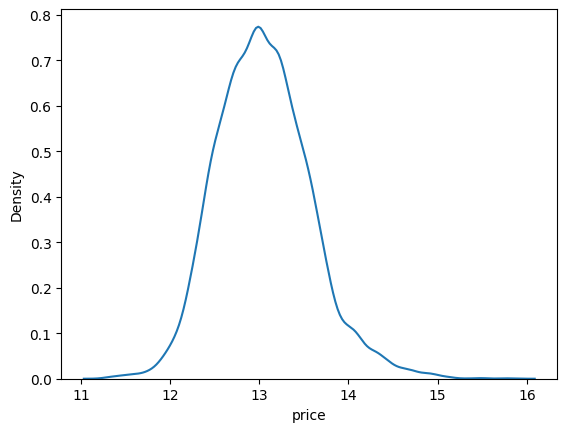

In [7]:
train_y = np.log1p(train_y) # logscale로 변환
sns.kdeplot(train_y) #target y 밀도 확인

In [8]:
#target과 feature 상관계수를 확인함으로써 지울 내용이 있는지 확인
t1=pd.concat([train.iloc[:,:9],train_y],axis=1)
t1.corr()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,price
id,1.000000,-0.013261,0.020899,0.010520,0.104030,0.041725,-0.034077,0.182848,-0.011775,0.035940
date,-0.013261,1.000000,0.007717,-0.002696,-0.022810,-0.022119,0.007500,-0.020891,-0.001742,0.009466
price,0.020899,0.007717,1.000000,0.323672,0.525479,0.702899,0.096793,0.262588,0.265738,0.887108
bedrooms,0.010520,-0.002696,0.323672,1.000000,0.530548,0.596974,0.033475,0.189532,-0.004819,0.359946
bathrooms,0.104030,-0.022810,0.525479,0.530548,1.000000,0.755853,0.089308,0.508649,0.075452,0.552000
sqft_living,0.041725,-0.022119,0.702899,0.596974,0.755853,1.000000,0.176500,0.363193,0.108137,0.697907
sqft_lot,-0.034077,0.007500,0.096793,0.033475,0.089308,0.176500,1.000000,0.001535,0.025584,0.108946
floors,0.182848,-0.020891,0.262588,0.189532,0.508649,0.363193,0.001535,1.000000,0.031159,0.317810
waterfront,-0.011775,-0.001742,0.265738,-0.004819,0.075452,0.108137,0.025584,0.031159,1.000000,0.172580
price,0.035940,0.009466,0.887108,0.359946,0.552000,0.697907,0.108946,0.317810,0.172580,1.000000


In [9]:
t2=pd.concat([train.iloc[:,9:],train_y],axis=1)
t2.corr()

,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
view,1.000000,0.045255,0.247924,0.172693,0.265880,-0.061670,0.107605,0.089247,0.005285,-0.073151,0.278267,0.076501,0.347506
condition,0.045255,1.000000,-0.143599,-0.152856,0.175064,-0.366590,-0.062342,0.001106,-0.015974,-0.110742,-0.091407,-0.003873,0.042947
grade,0.247924,-0.143599,1.000000,0.759240,0.162657,0.440608,0.030155,-0.186541,0.112319,0.202130,0.715321,0.119734,0.707412
sqft_above,0.172693,-0.152856,0.759240,1.000000,-0.048623,0.422431,0.031441,-0.258474,0.001074,0.347226,0.737795,0.194226,0.607197
sqft_basement,0.265880,0.175064,0.162657,-0.048623,1.000000,-0.136214,0.076452,0.067782,0.105969,-0.141792,0.198380,0.018813,0.314378
yr_built,-0.061670,-0.366590,0.440608,0.422431,-0.136214,1.000000,-0.215760,-0.354280,-0.156563,0.414565,0.324221,0.076009,0.076293
yr_renovated,0.107605,-0.062342,0.030155,0.031441,0.076452,-0.215760,1.000000,0.068307,0.034844,-0.070134,0.007995,-0.000348,0.127533
zipcode,0.089247,0.001106,-0.186541,-0.258474,0.067782,-0.354280,0.068307,1.000000,0.261312,-0.563455,-0.274176,-0.145710,-0.039195
lat,0.005285,-0.015974,0.112319,0.001074,0.105969,-0.156563,0.034844,0.261312,1.000000,-0.133460,0.048924,-0.081725,0.444417
long,-0.073151,-0.110742,0.202130,0.347226,-0.141792,0.414565,-0.070134,-0.563455,-0.133460,1.000000,0.333673,0.256201,0.054362


위치와 우편번호,컨디션 등 범주형 데이터들은 일단 그대로 진행

In [10]:
#상관계수 확인 후 특정 feature 제거, 재조합

del train['id']
del test['id']
del train['price']
train["point"]=train["bathrooms"]/train["bedrooms"] * train["condition"]
test["point"]=test["bathrooms"]/test["bedrooms"] * test["condition"]

In [11]:
def is_2014_lot(df):
  if df['date']//100 == 2014:
    return df['sqft_lot']
  else:
    return df['sqft_lot15']

test["lot"] = test.apply(is_2014_lot, axis=1)
train["lot"] = train.apply(is_2014_lot, axis=1)

In [12]:
def is_2014_living(df):
  if df['date']//100 == 2014:
    return df['sqft_living']
  else:
    return df['sqft_living15']

test["living"] = test.apply(is_2014_living, axis=1)
train["living"] = train.apply(is_2014_living, axis=1)

In [14]:
train["year"]= train['date'].apply(lambda i: i//100)
test["year"]= test['date'].apply(lambda i: i//100)
train["month"]= train['date'].apply(lambda i: i%100)
test["month"]=test['date'].apply(lambda i: i%100)

In [15]:
def age(df):
  if df['yr_renovated'] == 0:
    return df['year']-df['yr_built']
  else:
    return df['year']-df['yr_renovated']

train["age"] = train.apply(age, axis=1)
test["age"] = test.apply(age, axis=1)

In [23]:
train.head()

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_renovated,zipcode,lat,long,point,lot,living,year,month,age
0,3,1.00,1.0,0,0,3,7,1180,0,0,98178,47.5112,-122.257,1.00,5650.0,1180.0,2014,10,59.0
1,2,1.00,1.0,0,0,3,6,770,0,0,98028,47.7379,-122.233,1.50,8062.0,2720.0,2015,2,82.0
2,3,2.00,1.0,0,0,3,8,1680,0,0,98074,47.6168,-122.045,2.00,7503.0,1800.0,2015,2,28.0
3,3,2.25,2.0,0,0,3,7,1715,0,0,98003,47.3097,-122.327,2.25,6819.0,1715.0,2014,6,19.0
4,3,1.50,1.0,0,0,3,7,1060,0,0,98198,47.4095,-122.315,1.50,9711.0,1650.0,2015,1,52.0


In [18]:
#train=train.drop(['date','sqft_lot', 'sqft_lot15','yr_built','yr_renovated'],axis=1)
#test=test.drop(['date','sqft_lot', 'sqft_lot15','yr_built','yr_renovated'],axis=1)
#train=train.drop(['yr_built','yr_renovated'],axis=1)
#test=test.drop(['yr_built','yr_renovated'],axis=1)
train=train.drop(['date','sqft_lot', 'sqft_lot15','sqft_living','sqft_living15','yr_built'],axis=1)
test=test.drop(['date','sqft_lot', 'sqft_lot15','sqft_living','sqft_living15','yr_built'],axis=1)

In [19]:
train.shape

(15035, 19)

# 3.모델 생성

In [24]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

random_state=2020   

xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)


# 4.모델 하이퍼 파라미터 추정

In [25]:
def grid_hp(model):#사용한 파라미터 출력
  p=model.cv_results_['params']
  s=model.cv_results_['mean_test_score']
  results = pd.DataFrame(p)
  results['score'] = s
  results['RMSLE'] = np.sqrt(-1 * results['score'])
  results = results.sort_values('RMSLE')
  return results

In [32]:
from sklearn.model_selection import GridSearchCV
lightgbm_param_grid = {
    'learning_rate': [0.01],
    'max_depth': [15,20],
    'n_estimators': [3300,2000,4000]
    #'num_laves': [3000,4000]
}
#gboost 
#xgboost
#lightgbm
grid_model = GridSearchCV(lightgbm, param_grid=lightgbm_param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=3, verbose=2, n_jobs=8)
grid_model.fit(train, train_y)
grid_hp(grid_model).head() #lightgbm

Fitting 3 folds for each of 6 candidates, totalling 18 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
3,0.01,20,3300,-0.027285,0.165183
1,0.01,15,2000,-0.027322,0.165294
4,0.01,20,2000,-0.027330,0.165317
0,0.01,15,3300,-0.027349,0.165374
5,0.01,20,4000,-0.027352,0.165385


# 5. 예측값 출력

In [33]:
model = LGBMRegressor(learning_rate=0.01,max_depth=20, n_estimators=3300, random_state=random_state)
model.fit(train,train_y)

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()
#임의로 정한 한 개의 모델에 대한 점수 출력
prediction=np.expm1(model.predict(test))
submission['price'] = prediction
submission.head()
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'LGBM', '0.17')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)


/content/drive/MyDrive/EX03_data//submission_LGBM_RMSLE_0.17.csv


# 6. 회고록

최종적으로

private score 116185.9697

public score 112128.5528
을 기록했다.

개인적으로 kaggle 집값 예측 모델 학습을 진행하면서 다중모델 에버리징,feature 엔지니어링 등 여러 방식을 사용해봤던 결과 다중모델을 이용한 average 방식보단 개인적으로는 단일 모델을 이용하는 방식이 점수자체는 높았다.

또한 feature들에 대한 이상치들을 분석하여 제거하는 방식보다는 기존 feature들의 재구성 혹은 재조합을 진행하는 방식이 private score와 public score 간의 차이가 안정화되면서 score 점수 자체도 하락하는 추세를 보였다.

범주형 데이터들에 대해서 가공을 한다면 좀 더 높은 점수를 갱신할 것 같았다. 물론 위도 경도 우편번호와 같은 데이터들에 대하여 어떻게 가공할까 라는 의문점을 해결하지못하여 그 부분이 조금 아쉽다.

이후로도 조금 찾아보니 feature colum들의 순서에도 score의 차이 조금 발생한다는 내용도 있다는 점을 발견했다.

